** NAMED ENTITY RECOGNITION FOR WIKIPEDIA ARTCICLES USING CHARACTER-LEVEL EMBEDDINTGS**



# Importing Libraries


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.1
GPU detected: []


# Reading Wikipedia Dataset

In [ ]:
data = pd.read_csv("DataSet.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,AajTak,NNP,Org
1,Sentence: 1,is,VBZ,O
2,Sentence: 1,an,DT,O
3,Sentence: 1,Indian,JJ,Misc
4,Sentence: 1,Hindi,NNP,Misc
5,Sentence: 1,language,NN,O
6,Sentence: 1,news,NN,O
7,Sentence: 1,channel,NNS,O
8,Sentence: 1,owned,VBN,O
9,Sentence: 1,by,IN,O


# Preprocessing of Data

Length of words in a dataset

In [ ]:
len(data)

70418

Creating the list of unique words


In [ ]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

9360

Creating the list of unique tags


In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

5

Converting the dataframe into list of tuples 

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

Creating the word2idx, idx2word,tag2idx and idx2tag to map the every  unique word to an index and to map every unique tag to an index vice versa

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

Creating the list of unique characters

In [ ]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

88


Creating the char2idx to map every unique character to index


In [ ]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

Plotting the lengths of words in a sentence

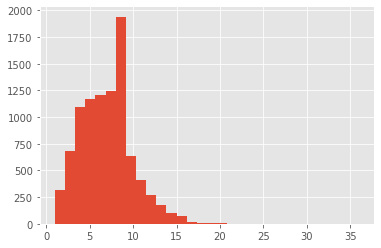

In [ ]:
plt.hist([len(w) for w in words],bins=30)
plt.show()

Plotting the lengths of sentences in a dataset

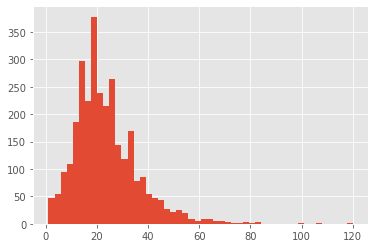

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

Taking maximum length of sentencs and words for padding

In [ ]:
max_len = 80
max_len_char = 20

Creating the 2-D list having mapped with indexes for every character of words in a sentences with padding

In [ ]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

Creating the 2-D list of tags as y with padding 

In [ ]:
from keras.preprocessing.sequence import pad_sequences

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

Splitting the dataset into training, validation and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_char_d, X_char_test, y_char_d, y_test= train_test_split(X_char, y, test_size=1/6,shuffle=False)

In [ ]:
X_char_train, X_char_val, y_train, y_val = train_test_split(X_char_d, y_char_d, test_size=0.2,shuffle=False)

# Training

Importing the model layers 

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

Arctitecture of model


In [ ]:
# Input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = Embedding(input_dim=n_chars +2, output_dim=15,
                           input_length=max_len_char, mask_zero=True)(char_in)

# Character LSTM to get word encodings by characters
char_enc = TimeDistributed(Bidirectional(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5)))(emb_char)

# Main LSTM
x = SpatialDropout1D(0.5)(char_enc)
main_lstm = Bidirectional(LSTM(units=224, return_sequences=True,
                               recurrent_dropout=0.5))(x)
main_lstm = Dense(256,activation='relu')(main_lstm)
main_lstm = Dropout(0.1)(main_lstm)
out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(main_lstm)

model = Model([char_in], out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 20)]          0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 20, 15)        1350      
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 40)            5760      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 80, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 448)           474880    
_________________________________________________________________
dense (Dense)                (None, 80, 256)           114944    
_________________________________________________________________
dropout (Dropout)            (None, 80, 256)           0     

Compiling of model


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
pip install livelossplot

Importing the module from libraries for Checkpoints, EarlyStopping and for Plotting of acuracy and loss curve for training and validation set

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

Training of model on training set and evaluating on validation set

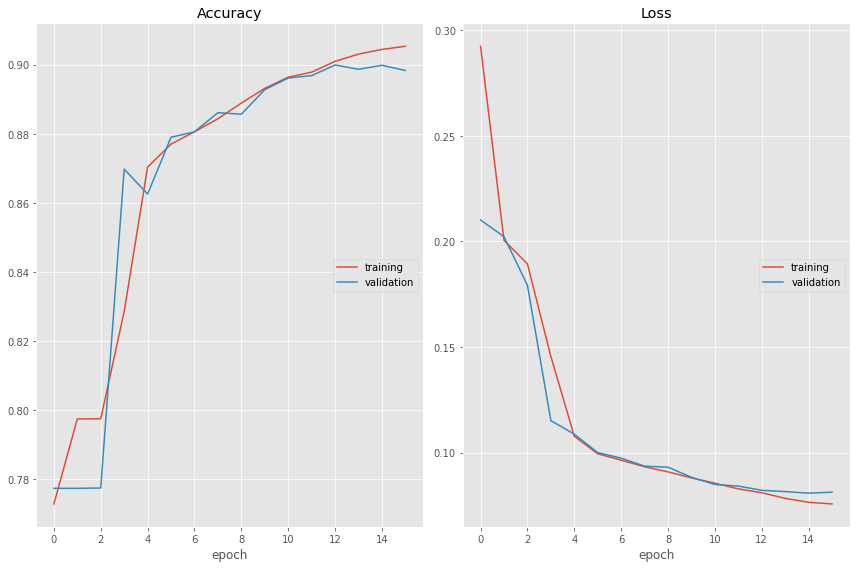

Accuracy
	training         	 (min:    0.773, max:    0.905, cur:    0.905)
	validation       	 (min:    0.777, max:    0.900, cur:    0.898)
Loss
	training         	 (min:    0.076, max:    0.292, cur:    0.076)
	validation       	 (min:    0.081, max:    0.210, cur:    0.081)

Epoch 00016: val_loss did not improve from 0.08082
CPU times: user 33min 3s, sys: 2min 25s, total: 35min 28s
Wall time: 18min 31s


In [ ]:
%%time

chkpt = ModelCheckpoint("model_weights_cha.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKeras(), chkpt, early_stopping]

history = model.fit(
    np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char)),
    np.array(y_train).reshape(len(y_train), max_len, 1),
    validation_data=(np.array(X_char_val).reshape((len(X_char_val), max_len, max_len_char)),np.array(y_val).reshape(len(y_val), max_len, 1)),
    batch_size=64, 
    epochs=50,
    callbacks=[callbacks],
    verbose=1
)

# Prediction on Test Set

Predicting the probabilities of tags for the test set

In [ ]:
y_pred = model.predict(np.asarray(X_char_test).astype('int32').reshape((len(X_char_test),max_len, max_len_char)))

In [ ]:
model.evaluate(np.asarray(X_char_test).astype('int32').reshape((len(X_char_test),max_len, max_len_char)),np.array(y_test).reshape(len(y_test), max_len, 1))

16/16 [==============================] - 4s 199ms/step - loss: 0.0898 - acc: 0.8905


[0.08975569158792496, 0.8904753923416138]

# Performance Metrices

Importing the module for metrices used for NER  

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,confusion_matrix

Converting the predicted probabalities of labels into the tags

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(y_pred)

Converting the indexed tags of true labels into tags

In [ ]:
def true2label(true_l):
    out = []
    for pred_i in true_l:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "O"))
        out.append(out_i)
    return out

In [ ]:
test_labels = true2label(y_test)

Calculating the F1-score for the test set

In [ ]:
print("F1-score: {:.1%}".format(f1_score(np.asarray(test_labels).reshape(-1,1),np.asarray(pred_labels).reshape(-1,1),average='micro')))

F1-score: 96.7%


Classification Report of the test set

In [ ]:
print(classification_report(np.asarray(test_labels).reshape(-1,1),np.asarray(pred_labels).reshape(-1,1)))

              precision    recall  f1-score   support

         Loc       0.71      0.60      0.65       569
        Misc       0.73      0.10      0.18        78
           O       0.99      0.99      0.99     37753
         Org       0.60      0.77      0.68      1461
         Per       0.25      0.04      0.06       139

    accuracy                           0.97     40000
   macro avg       0.66      0.50      0.51     40000
weighted avg       0.97      0.97      0.97     40000



Printing the words with corrected tags and predicted tags for a sentences at index i in the test set

In [ ]:
i = 7
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], y_test[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Confusion matrix of test set

In [ ]:
print(confusion_matrix(np.asarray(test_labels).reshape(-1,1),np.asarray(pred_labels).reshape(-1,1)))

[[  343     2    84   133     7]
 [   29     8    28    13     0]
 [   26     0 37215   508     4]
 [   61     1   270  1125     4]
 [   24     0    27    83     5]]
